##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


### Explain what each column of data means

- X and Y: They are the coordinates(Latitude and Longitude) of the location where the incident was reported.

- Area_Command: The police department that is in charge of the area, So each department has its numerical code.

- NIBRSOffenseCode: Its the code for the classification of the crime committed. Each numerical value classifies different crime.

- DayOfWeek: The day of the week when the incident was reported (0 for Sunday, 1 for Monday, and so on).

- Time: The hour of the day(in number denote the hours of the day) when the incident was reported .

- VictimCount: The number of persons involved in the incident.

### Identify the input and target variables

**Input Variables:**
- Latitude (X)
- Longitude (Y)
- Hour of the day (Time)
- Day of the week (DayOfWeek)
- Area-of-command code (Area_Command)
- Classification code for the crime committed (NIBRSOffenseCode)

**Target Variable:**
- Number of persons involved in the incident (VictimCount)


### What is the range of values in each column? Do you need to scale, shift or normalize your data?

- X: The range of latitude hovers over the area of Las vegas and should vary by decimal points(-115.xxxxx).
- Y: The range of longitude hovers over the area of Las vegas and should vary by decimal points(36.xxxxx).
- Area_Command: The range of integers depends on the number of unique area commands in the dataset.
- NIBRSOffenseCode: The range of integers depends on the number of unique offense codes in the dataset.
- DayOfWeek: It ranges from 0 to 6 representing Monday to Sunday.
- Time: It ranges from 0 to 23  representing the unique hours of the day.
- VictimCount: The Integer range depends on the number of unique victim counts in the dataset.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [8]:
# Converting DataFrame to PyTorch tensors
X = torch.Tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values)
y = torch.Tensor(df['VictimCount'].values)

batch_size = 64

# Creating TensorDataset and DataLoader for training and testing
dataset = TensorDataset(X, y)

train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [9]:
import torch.nn as nn
import torch.optim as optim

# Defining the loss function as mean squared error
loss_function = nn.MSELoss()

# Defining a sequential model
model = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

# Selecting adam as optimizer and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Calculating the loss and adjusting the weights for best accuarcy
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets.view(-1, 1))
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train MSE: {train_losses[-1]:.4f} - Test MSE: {test_losses[-1]:.4f}")

final_test_loss = test_losses[-1]
print(f"Final Test MSE: {final_test_loss:.4f}")


Epoch [1/50] - Train MSE: 1.5058 - Test MSE: 0.8542
Epoch [2/50] - Train MSE: 1.0611 - Test MSE: 0.7477
Epoch [3/50] - Train MSE: 0.9926 - Test MSE: 0.7323
Epoch [4/50] - Train MSE: 1.0310 - Test MSE: 0.7379
Epoch [5/50] - Train MSE: 1.1240 - Test MSE: 0.7797
Epoch [6/50] - Train MSE: 0.9685 - Test MSE: 0.7578
Epoch [7/50] - Train MSE: 0.9501 - Test MSE: 0.7628
Epoch [8/50] - Train MSE: 1.0927 - Test MSE: 0.7462
Epoch [9/50] - Train MSE: 1.0002 - Test MSE: 0.7900
Epoch [10/50] - Train MSE: 1.0507 - Test MSE: 0.7369
Epoch [11/50] - Train MSE: 1.1306 - Test MSE: 0.7442
Epoch [12/50] - Train MSE: 1.1027 - Test MSE: 0.7884
Epoch [13/50] - Train MSE: 1.0059 - Test MSE: 0.7388
Epoch [14/50] - Train MSE: 1.0402 - Test MSE: 0.7398
Epoch [15/50] - Train MSE: 0.9429 - Test MSE: 0.7579
Epoch [16/50] - Train MSE: 1.0645 - Test MSE: 0.7359
Epoch [17/50] - Train MSE: 0.9970 - Test MSE: 0.7609
Epoch [18/50] - Train MSE: 0.9885 - Test MSE: 0.7371
Epoch [19/50] - Train MSE: 1.0049 - Test MSE: 0.7457
Ep

### What should the size of the predicted output be?
The size of the predicted output should be 1 since we are predicting the number of victims involved(VictimCount) in the crime.

### Explain your choice of architecture, including how many layers you will be using

The architecture is a feedforward neural network consisting of several fully connected (linear) layers with ReLU activation functions inbetween the linear layers.

- **Input Layer**: You start with an input layer with 6 units. This number corresponds to the number of features or input dimensions in your data.

- **Hidden Layers**: You have a series of hidden layers, each with a different number of units. This architecture allows the network to learn and capture complex patterns and relationships within the data. You have chosen the following hidden layers:
   - Layer 1: 64 units with ReLU activation.
   - Layer 2: 128 units with ReLU activation.
   - Layer 3: 128 units with ReLU activation.
   - Layer 4: 64 units with ReLU activation.


- **Output Layer**: The output layer has 1 unit which corresponds to the regression nature of the problem. The goal is to predict a continuous value (real number), and therefore, you only need a single unit in the output layer.

The choice of the number of units in each layer depends on the complexity of your dataset and the problem you're trying to solve. After changing the number of units, adding or removing layers, and trying different activation functions, to find the best architecture for the specific regression task.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [10]:
# Function to calculate the accuracy of the dataset
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / len(targets)
    return accuracy

In [11]:
# Initializing the number of unique classes in the output data
num_classes = len(df['VictimCount'].unique())

# Changing the loss function to crossentropy for classification
loss_function = nn.CrossEntropyLoss()

# Defining the sequential model just changing the output size to the number of classes
model = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes),
)

# Defining adam optimizer and leraning rate as 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Calculating the loss and updating the weights.
num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.long()
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            targets = targets.long()
            accuracy = calculate_accuracy(outputs, targets)
            correct_predictions += accuracy * len(targets)
            total_samples += len(targets)

    accuracy = 100 * correct_predictions / total_samples
    if accuracy > best_accuracy:
        best_accuracy = accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}] - Accuracy: {accuracy:.4f}%")

print(f'Best Test Accuracy: {best_accuracy:.2f}%')


Epoch [1/50] - Accuracy: 52.7273%
Epoch [2/50] - Accuracy: 52.7273%
Epoch [3/50] - Accuracy: 52.7273%
Epoch [4/50] - Accuracy: 52.7273%
Epoch [5/50] - Accuracy: 52.7273%
Epoch [6/50] - Accuracy: 52.7273%
Epoch [7/50] - Accuracy: 52.7273%
Epoch [8/50] - Accuracy: 52.7273%
Epoch [9/50] - Accuracy: 52.7273%
Epoch [10/50] - Accuracy: 52.7273%
Epoch [11/50] - Accuracy: 52.7273%
Epoch [12/50] - Accuracy: 52.7273%
Epoch [13/50] - Accuracy: 54.5455%
Epoch [14/50] - Accuracy: 52.7273%
Epoch [15/50] - Accuracy: 52.7273%
Epoch [16/50] - Accuracy: 52.7273%
Epoch [17/50] - Accuracy: 52.7273%
Epoch [18/50] - Accuracy: 52.7273%
Epoch [19/50] - Accuracy: 54.5455%
Epoch [20/50] - Accuracy: 52.7273%
Epoch [21/50] - Accuracy: 52.7273%
Epoch [22/50] - Accuracy: 52.7273%
Epoch [23/50] - Accuracy: 52.7273%
Epoch [24/50] - Accuracy: 52.7273%
Epoch [25/50] - Accuracy: 52.7273%
Epoch [26/50] - Accuracy: 52.7273%
Epoch [27/50] - Accuracy: 52.7273%
Epoch [28/50] - Accuracy: 50.9091%
Epoch [29/50] - Accuracy: 52.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

### Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?

Task 3 is a regression problem because its objective is to predict the actual number of crime victims. The regression model's multiple hidden layers helped to lower the Mean Squared Error (MSE) loss over epochs
Task 4 becomes a classification problem as it moves to categorizing the quantity of crime victims. The unique classes in the dataset's 'VictimCount' column determine the total number of output classes. The only difference between the model architecture and the one in Task 3 is the output layer, which has a number of units equal to the number of classes. The loss function is changed to CrossEntropy.

Comparing Task 3 and Task 4's outcomes:

- In general, task 4 (classification) yields superior outcomes when assessing the model's performance. This is so that classification problems are more appropriate in situations where you wish to group data into particular classes.

- The squared difference between the expected values and the actual targets is used to calculate the mean square error (MSE), which is used to evaluate the model's performance in Task 3 (regression). But it's possible that the MSE value can't always be understood clearly.

- Accuracy is the evaluation metric for Task 4. Since accuracy in classification tasks refers to the percentage of correctly classified data points, it is easier to interpret and comprehend.

- Comparing the two tasks, Task 4 is a better fit because its outcomes have greater significance when it comes to categorizing crime victim counts. Regression vs. classification, however, is determined by the particular issue at hand as well as the type of data you hope to extract from the model.


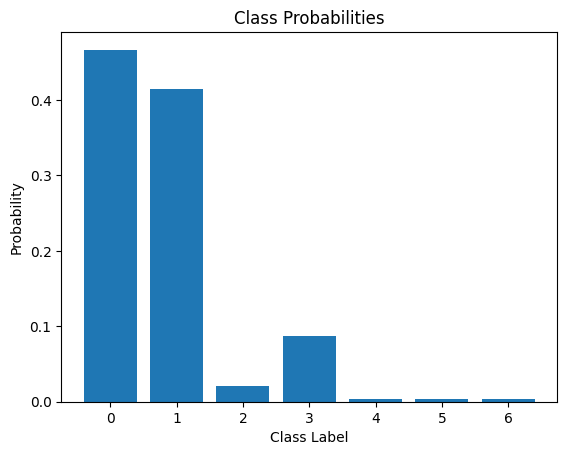

Correct Label: 1.0, Predicted Class: 0


In [12]:
import matplotlib.pyplot as plt
import random

# Evaluating the model
model.eval()

# Choosing a random data sample from the dataset
sample_index = random.randint(0, len(test_dataset))
sample = test_dataset[sample_index]

# Get the input data
input_data, correct_label = sample
input_data = input_data.view(1, -1)

# Predicting the output
with torch.no_grad():
    output = model(input_data)
    predicted_class = torch.argmax(output, dim=1)

# Now to calculate the probabilites of the ouput classes we use softmax function
probabilities = torch.softmax(output, dim=1)[0]

class_labels = df['VictimCount'].unique()

plt.bar(class_labels, probabilities)
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.show()

print(f"Correct Label: {correct_label}, Predicted Class: {predicted_class.item()}")

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


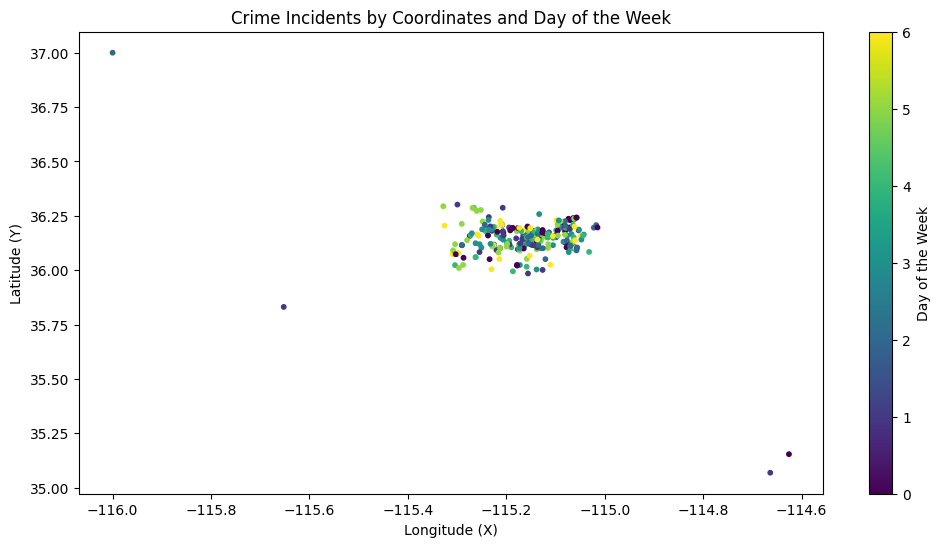

In [13]:
# Scatter plot based on coordinates, with colors indicating the day of the week
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10)
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Coordinates and Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

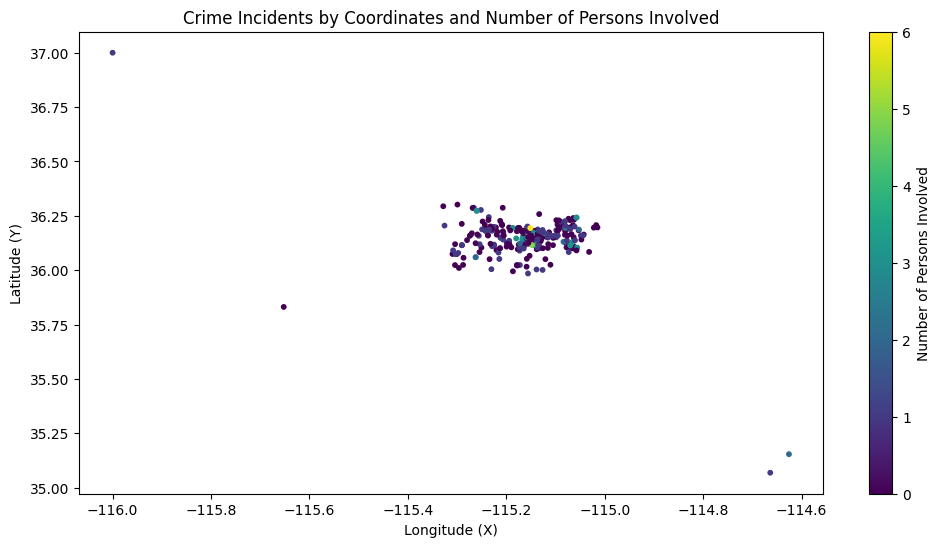

In [14]:
# Scatter plot based on coordinates, with colors indicating the number of persons involved
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=10)
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates and Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

In [15]:
# Sort the number of crimes reported by day of the week
day_counts = df['DayOfWeek'].value_counts().sort_index()
print(day_counts)

# Print the most frequent days
most_frequent_days = day_counts.idxmax()
print(f"The most frequent day is {most_frequent_days} with {day_counts.max()} reported crimes.")

DayOfWeek
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: count, dtype: int64
The most frequent day is 4 with 51 reported crimes.
